## Семинар 7: "Методы оптимизации"

ФИО: Намит Максим Михайлович

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG - OK, 
    
    Adagrad, Adadelta, Adam. - To Do</i>

In [2]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.1):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad
                
class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                
class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
        
        self.v = [torch.zeros_like(param) for param in self.parameters]
        
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        
        super().step(F)
        
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
                
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate * 10
        
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 10e-9
        
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

class Adagrad(Optimizer):
    def __init__(self, parameters, eps=1e-8, learning_rate=0.1):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = eps
        
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(g + param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad

class Adadelta(Optimizer):
    def __init__(self, parameters, gamma=0.9, learning_rate=0.1):
        super().__init__(parameters)
        self.params_gs = [torch.zeros_like(param) for param in self.parameters]
        
        self.first_call = True
        
        self.lr = learning_rate
        self.eps = 0.00001
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        
        sum_step = 0
        num_params = 0
        with torch.no_grad():
            for param, gs in zip(self.parameters, self.params_gs):
                if not self.first_call:
                    gs.copy_(self.gamma * gs + (1.0 - self.gamma) * param.grad ** 2)
                else:
                    gs.copy_(param.grad ** 2)

                step = self.lr / (gs + self.eps).sqrt() * param.grad
                sum_step += step.sum()
                num_params += step.numel()
                param -= step

        self.lr = self.gamma * self.lr + (1 - self.gamma) * sum_step / num_params
        self.first_call = False

class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, beta1=0.9, beta2=0.999, eps=1e-7):
        super().__init__(parameters)

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        
        self.m_ = [torch.zeros_like(param) for param in self.parameters]
        self.v_ = [torch.zeros_like(param) for param in self.parameters]

        self.eps = eps
        self.num_step = 0
    
    def step(self, F):
        super().step(F)
        self.num_step += 1
        
        with torch.no_grad():
            for param, v, m in zip(self.parameters, self.v_, self.m_):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)

                v.copy_(self.beta2 * v + (1 - self.beta2) * (param.grad ** 2))
                
                m_help = m / (1 - (self.beta1 ** self.num_step))
                v_help = v / (1 - (self.beta2 ** self.num_step))

                param -= self.learning_rate * m_help / (v_help ** 0.5 + self.eps)

In [3]:
def plot_graphics(F, optimizers, colors):
    x_0 = np.array([2.5, 1.5]).reshape(1, -1)

    optim_path = []

    for optim in optimizers:
        #print(optim.__name__)

        x = torch.tensor(x_0, requires_grad=True)
        optim = optim([x])

        points = []

        for i in range(200):
            p_z = F(x).item()        
            p_x, p_y = x.detach().numpy().flatten()        
            #print(p_z, p_x, p_y)
            points.append((p_x, p_y, p_z))

            optim.step(lambda: F(x))
            optim.zero_grad()

        optim_path.append(points)
    
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a basic wireframe.
    #ax.plot_wireframe(space, space, Z)

    for color, path in zip(colors, optim_path):
        points = np.array(path)
        #print(points)
        points += np.random.rand(3) * 0.04
        ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)

    """
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)
    """

    #ax.view_init(30, 45)
    plt.show()
    
    for color, path in zip(colors, optim_path):
        points = np.array(path)        
        plt.plot(points[:, 0], points[:, 1], color=color, linewidth=5)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

/home/namitmax/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


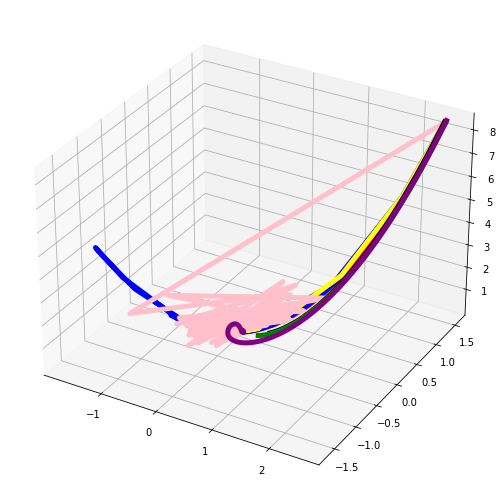

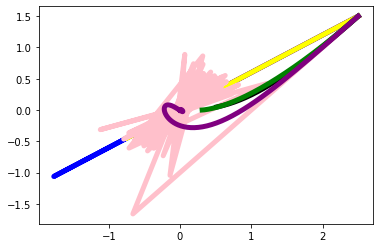

In [4]:
def F_0(x):    
    x, y = x[:, 0], x[:, 1]
    return x**2 + y**2

plot_graphics(F_0, [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam], \
              ["red", "blue", "yellow", "pink", "black", "green", "purple"])

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

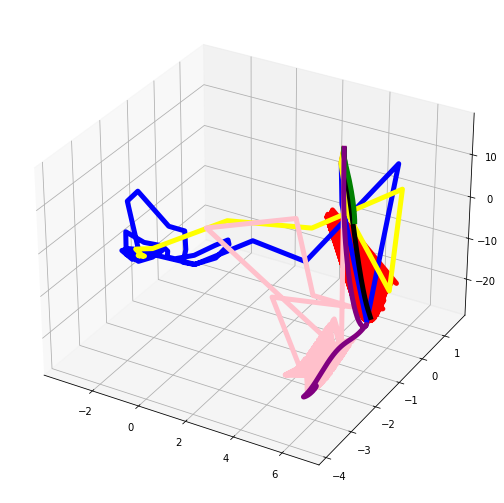

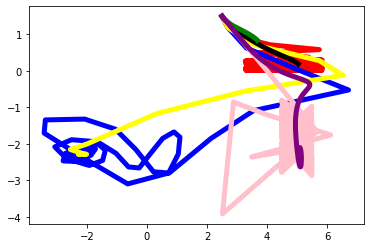

In [5]:
def F_1(x):    
    x, y = x[:, 0], x[:, 1]
    return (torch.sin(x) * x**2 + torch.sin(y) * y**2)

plot_graphics(F_1, [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam],\
              ["red", "blue", "yellow", "pink", "black", "green", "purple"])

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

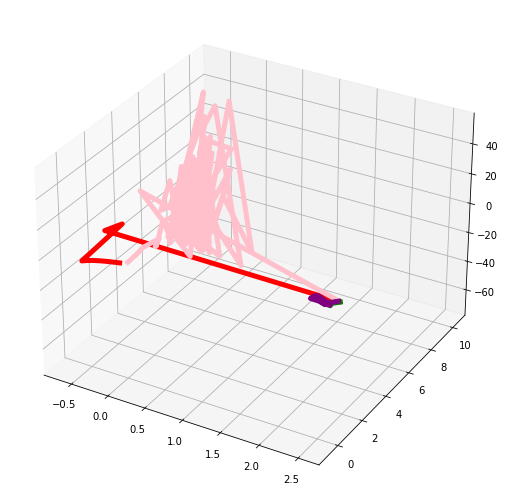

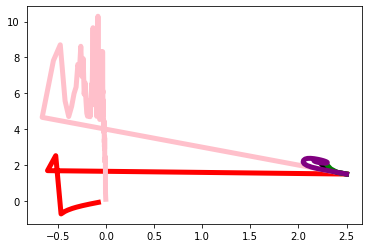

In [6]:
def F_2(x):    
    x, y = x[:, 0], x[:, 1]
    return (torch.sin(x**2) * x**2 + torch.sin(y**2) * y**2)

plot_graphics(F_2, [SGD, RMSProp, Adagrad, Adadelta, Adam], ["red", "pink", "black", "green", "purple"])

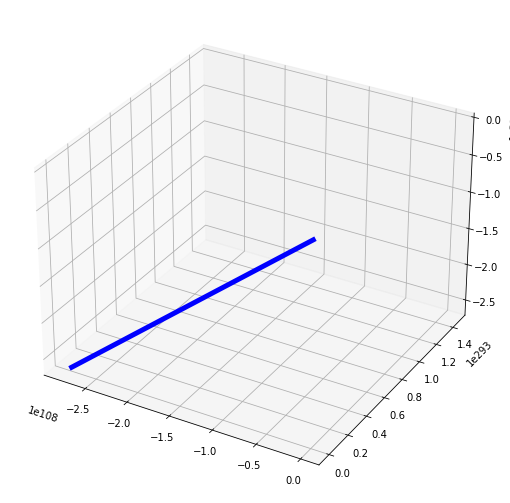

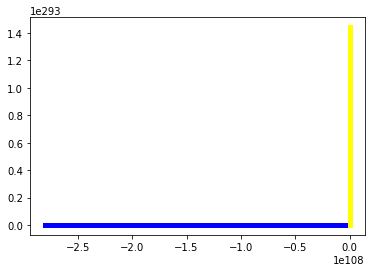

In [7]:
def F_2(x):    
    x, y = x[:, 0], x[:, 1]
    return (torch.sin(x**2) * x**2 + torch.sin(y**2) * y**2)

plot_graphics(F_2, [Momentum, NAG], ["blue", "yellow"])

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [9]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-27 11:39:26--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-27 11:39:26--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [              <=>   ]  33.20M  2.85MB/s    in 31s     

2021-03-27 11:39:57 (1.08 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [10]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [11]:
from IPython.display import clear_output

In [12]:
def train(network, epochs, optimizer):
    loss = nn.NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                #loss_batch.backward()
                optimizer.step(lambda :loss(prediction, y))
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [13]:
image_size = 28
channels = 1
class Net(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                          nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
                                          nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//4*image_size//4*64, 100), nn.ReLU(),
                                           nn.Linear(100, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.221/0.185	Accuracy: 0.933/0.944


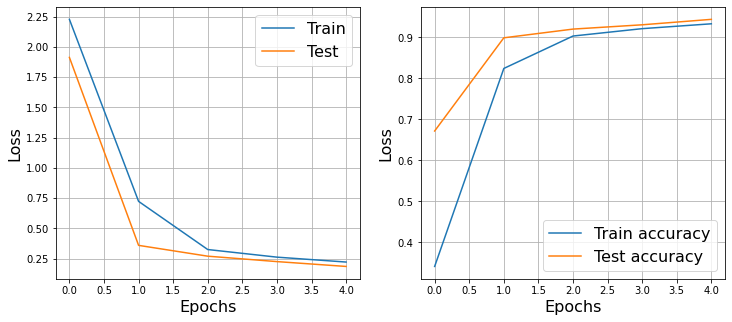

In [15]:
convNet = Net(image_size=28)
train(convNet, 5, SGD(convNet.parameters(), learning_rate=0.001))

Epoch 4... (Train/Test) NLL: 0.015/0.025	Accuracy: 0.996/0.992


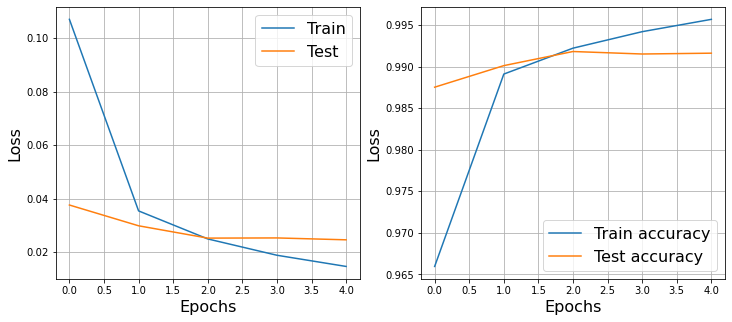

In [16]:
convNet = Net(image_size=28)
train(convNet, 5, Adagrad(convNet.parameters(), learning_rate=0.01))

Epoch 4... (Train/Test) NLL: 1.468/1.454	Accuracy: 0.668/0.685


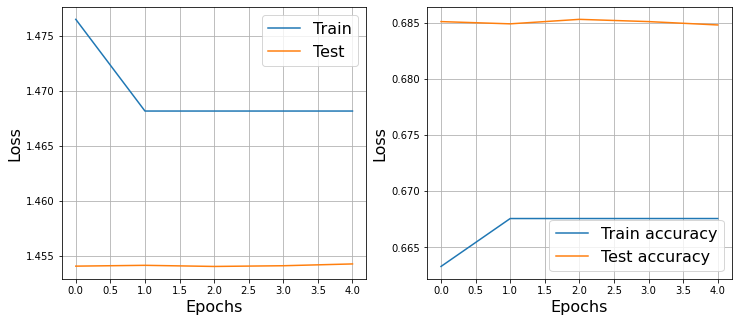

In [21]:
convNet = Net(image_size=28)
train(convNet, 5, Adadelta(convNet.parameters(), learning_rate=0.001))

Epoch 4... (Train/Test) NLL: 0.126/0.140	Accuracy: 0.962/0.959


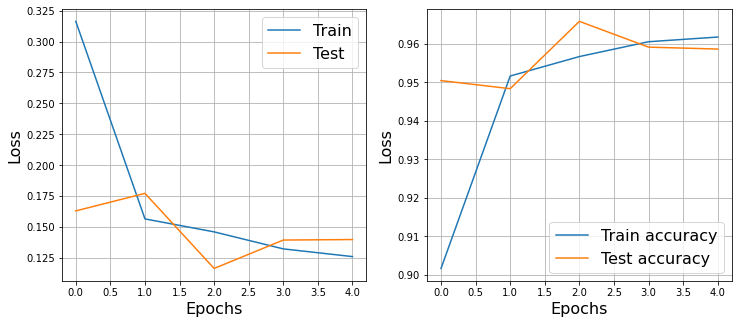

In [22]:
convNet = Net(image_size=28)
train(convNet, 5, Adam(convNet.parameters(), learning_rate=0.01))

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: